# Deskewing
When working with [single objective light sheet microscopy](https://andrewgyork.github.io/high_na_single_objective_lightsheet/), a special image processing step is necessary to reconstruction spatially corrected image stacks. This processing step is called "deskewing". Since version 0.14.0, pyclesperanto_prototype has a function for that.

In [3]:
from skimage.io import imread
import matplotlib.pyplot as plt
import pyclesperanto_prototype as cle

cle.get_device()

<Apple M1 Max on Platform: Apple (2 refs)>

In [4]:
original_image = imread('../../data/RBC_tiny.tif')
original_image.shape

(834, 118, 209)

The example image data shown below was kindly provided by 
[Dr George Ashdown](https://au.linkedin.com/in/george-ashdown-33559947?trk=public_post_share-update_update-text) and [Dr Niall Geoghegan](https://uk.linkedin.com/in/niall-geoghegan-72aa2446?trk=public_post_share-update_update-text) from the [WEHI, Melbourne, Australia](https://www.linkedin.com/company/wehi_research?trk=public_post_share-update_actor-text) who used lattice light sheet microscopy to capture immune cells called neutrophils.

In these so called raw data images taken with single-objective light sheet microscopes, the Z-plane is swept through the sample in a tilted way. This is not obvious when studying the Z-planes of the given stack:

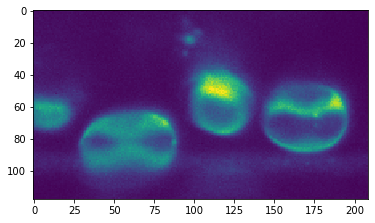

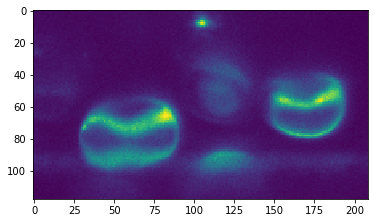

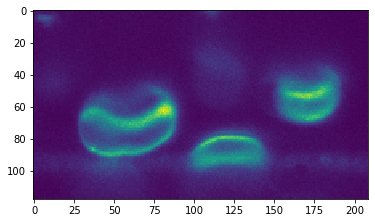

In [5]:
cle.imshow(original_image[0])
cle.imshow(original_image[5])
cle.imshow(original_image[10])

When looking at this image stack from the side, one can see the tilt of the light sheet orientation.

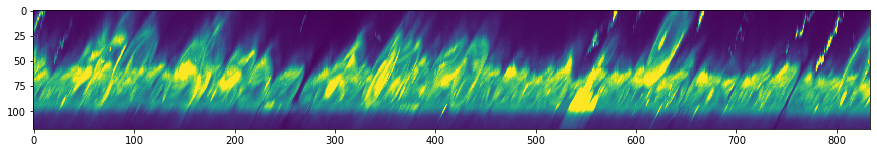

In [6]:
fig, axs = plt.subplots(1, 1, figsize=(15,15))

cle.imshow(cle.maximum_x_projection(original_image), plot=axs)

## Deskewing in action
Removing this tilt from the raw data is technially a [shearing](https://en.wikipedia.org/wiki/Shear_matrix), which is a rather uncommon part of an [affine transform](https://en.wikipedia.org/wiki/Affine_transformation#Image_transformation).

In pyclesperanto, we have a `deskew_y()` function that takes an input image and the sweep-angle as input:

In [7]:
deskewed = cle.deskew_y(original_image, angle_in_degrees=30)

deskewed.shape

(102, 1022, 209)

In [98]:
def scale_in_z_with_pixel_size(transform, angle_in_degrees: float = 0, pixel_size_xy: float = 0, pixel_size_z: float = 0 ):
    """Scales the image in Z-plane (a.k.a. YZ-plane) to create isotropic pixels. 
    Use this in combination with shear_in_x_plane
    Args:
        angle_y_in_degrees (float): Shearing angle in Y
        pixel_size_xy (float, optional): [description]. Defaults to 0.
        pixel_size_z (float, optional): [description]. Defaults to 0.
    """        
    new_dz = math.sin(angle_in_degrees * math.pi / 180.0) * pixel_size_z
    try:
        scale_factor = new_dz/pixel_size_xy
    except ZeroDivisionError:
        scale_factor = None
    return transform.scale(scale_z = scale_factor)

from pyclesperanto_prototype import plugin_function, Image, create_none
import math

@plugin_function(output_creator=create_none)
def deskew_y_PR(input_image: Image, output_image: Image = None, angle_in_degrees: float = 30, dxy:float =0, dz:float =0) -> Image:
    """
    Deskew an image stack as aquired with single-objective light-sheet microscopy.

    Parameters
    ----------
    input_image: Image
        raw image data with Z-planes representing the swept acquisition plane
    output_image: Image, optional
        reconstructed image data with Z-planes in proximal-distal oriental from the objective
    angle_in_degrees: float, optional
        default: 30 degrees

    Returns
    -------
    output_image
    """

    from pyclesperanto_prototype import AffineTransform3D
    from pyclesperanto_prototype import affine_transform

    # shear in the X plane towards Y
    transform = AffineTransform3D()
    transform.shear_in_x_plane(angle_y_in_degrees=angle_in_degrees)

    # rotate the stack to get proper Z-planes
    transform.rotate(angle_in_degrees=angle_in_degrees, axis=0)

    # correct orientation so that the new Z-plane goes proximal-distal from the objective.
    transform.rotate(angle_in_degrees=90, axis=0)
    
    # MODIFIED SCALING (PR)
    scale_in_z_with_pixel_size(transform, angle_in_degrees,pixel_size_xy=dxy,pixel_size_z=dz)

    # apply transform
    return affine_transform(input_image, output_image, transform=transform, auto_size=True)

@plugin_function(output_creator=create_none)
def deskew_y_RH(input_image: Image, output_image: Image = None, angle_in_degrees: float = 30, dxy:float =0, dz:float =0) -> Image:
    """
    Deskew an image stack as aquired with single-objective light-sheet microscopy.

    Parameters
    ----------
    input_image: Image
        raw image data with Z-planes representing the swept acquisition plane
    output_image: Image, optional
        reconstructed image data with Z-planes in proximal-distal oriental from the objective
    angle_in_degrees: float, optional
        default: 30 degrees

    Returns
    -------
    output_image
    """

    from pyclesperanto_prototype import AffineTransform3D
    from pyclesperanto_prototype import affine_transform

    # shear in the X plane towards Y
    transform = AffineTransform3D()  
    transform.shear_in_x_plane(angle_y_in_degrees=angle_in_degrees)

    # rotate the stack to get proper Z-planes
    transform.rotate(angle_in_degrees=angle_in_degrees, axis=0)
    
    # MODIFIED SCALING (RH)
    transform.scale(scale_x=dxy/dz, scale_y=dxy/dz, scale_z=1)
    
    # correct orientation so that the new Z-plane goes proximal-distal from the objective.
    transform.rotate(angle_in_degrees=90, axis=0)
    
    # apply transform
    return affine_transform(input_image, output_image, transform=transform, auto_size=True)



In [99]:
voxel_size_x = 0.1449922
voxel_size_y = 0.1449922
voxel_size_z = 0.3

deskewed_pr = deskew_y_PR(original_image, angle_in_degrees=30, dxy=voxel_size_x, dz=voxel_size_z)
deskewed_pr.shape

(105, 1022, 209)

In [100]:
deskewed_rh = deskew_y_RH(original_image, angle_in_degrees=30, dxy=voxel_size_x, dz=voxel_size_z)
deskewed_rh.shape

(49, 1022, 101)

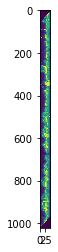

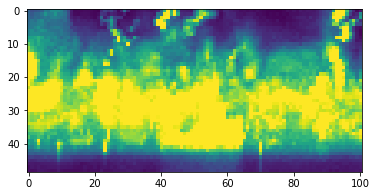

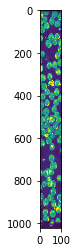

In [101]:
cle.imshow(cle.maximum_x_projection(deskewed_rh))
cle.imshow(cle.maximum_y_projection(deskewed_rh))
cle.imshow(cle.maximum_z_projection(deskewed_rh))

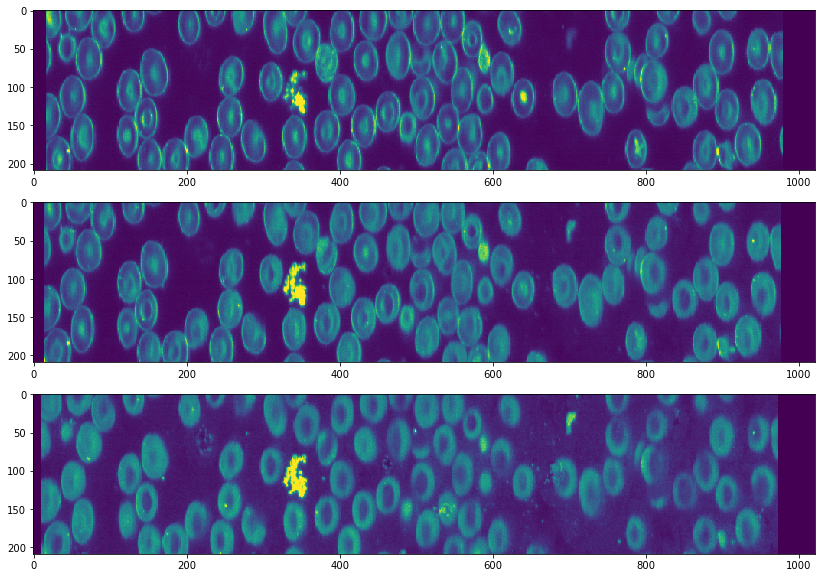

In [97]:
fig, axs = plt.subplots(3, 1, figsize=(30,10))

cle.imshow(deskewed_pr[75].T, plot=axs[0])
cle.imshow(deskewed_pr[80].T, plot=axs[1])
cle.imshow(deskewed_pr[85].T, plot=axs[2])

The resulting image has a quite different size because the image stack is not just sheared, it is also rotated in a way that the Z-planes of the resulting image stack correspond to an orientation that the Z-axis goes in proximal-distal orientation from the objective. As if we hat acquired an image using a confocal microscope. 

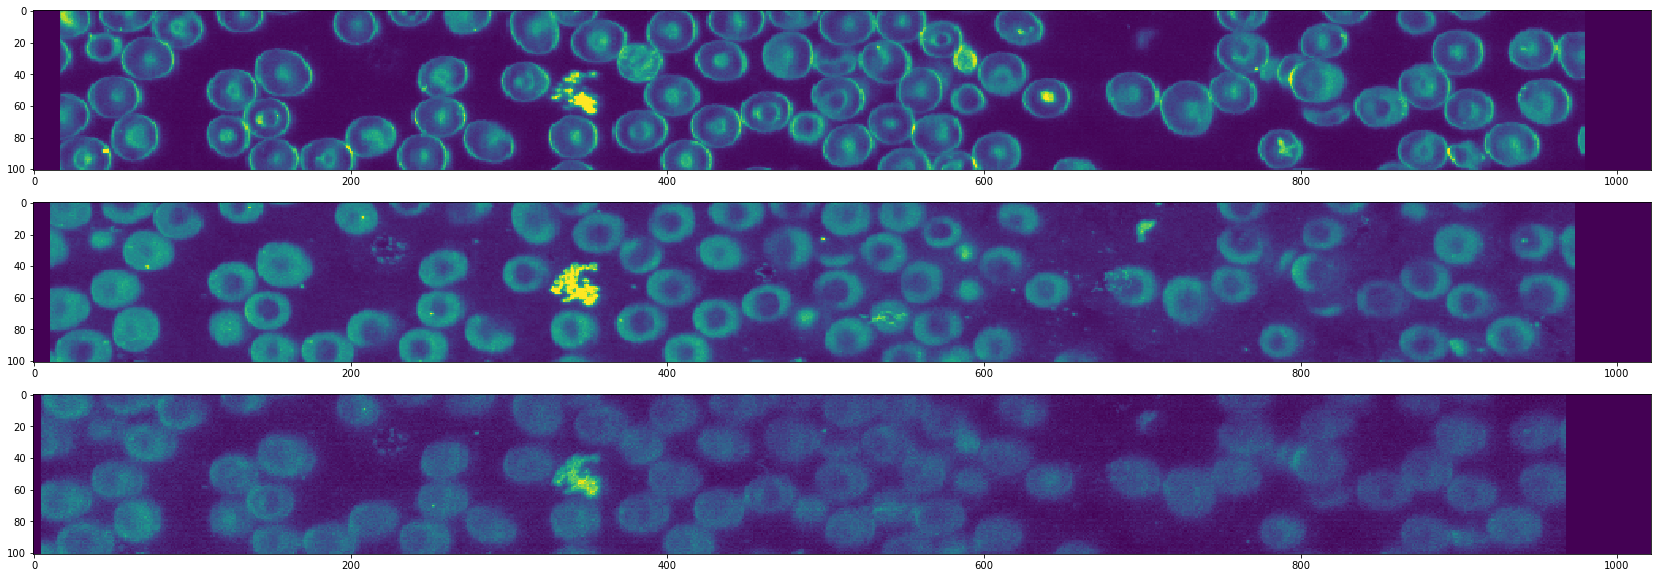

In [103]:
fig, axs = plt.subplots(3, 1, figsize=(30,10))

cle.imshow(deskewed_rh[35].T, plot=axs[0])
cle.imshow(deskewed_rh[40].T, plot=axs[1])
cle.imshow(deskewed_rh[45].T, plot=axs[2])

### If we project this stack from the side, we see the deskewed tilt, especially in comparison again the projected original image

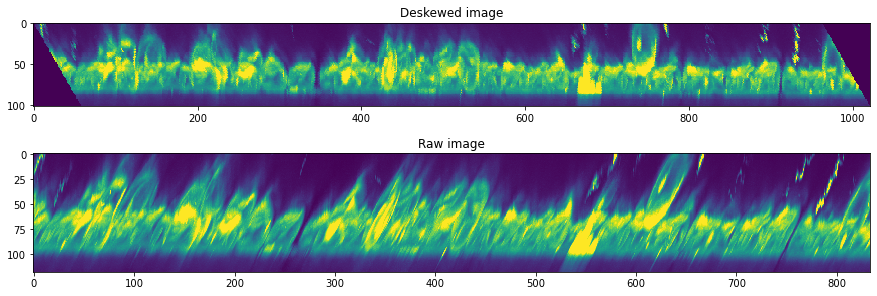

In [7]:
fig, axs = plt.subplots(2, 1, figsize=(15,5))

cle.imshow(cle.maximum_x_projection(cle.flip(deskewed, flip_z=False)).T, plot=axs[0])
axs[0].title.set_text("Deskewed image")
cle.imshow(cle.maximum_x_projection(original_image), plot=axs[1])
axs[1].title.set_text("Raw image")